# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle
from ConvLSTM_pytorch import convlstm_wdo as convlstm
import operator
from utils_v4 import *

# Load Data

In [2]:
#selected subset of dates. 
val_dates = ['180409','180412','180414']
test_dates = ['180411', '180413']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/'
model_saving_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/convLSTM_models'





## Load data helper functions

In [3]:
def create_files_new(load_path, bad_dates, T_length=10, proceed=1): 
    sleep_files = os.listdir(load_path+'sleep/')
    move_files = os.listdir(load_path+'move/')
    all_files = sleep_files+move_files
    
    dic = {}
    for f in all_files:
        mvmt_type = f.split('_')[-1].split('.')[0]
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        time = float(f.split('_')[3][4:])
        if date in bad_dates:
            continue
        if mvmt_type == 'sleep':
            label = 1
        else:
            label = 0
        if date in dic:
            if rec in dic[date]:
                dic[date][rec].append([f, label, mvmt_type, date, rec, time])
            else:
                dic[date][rec] = [[f, label, mvmt_type, date, rec, time]]
        else:
            dic[date] = {rec: [[f, label, mvmt_type, date, rec, time]]}
        
    for d in dic:
        for r in dic[d]:
            dic[d][r] = sorted(dic[d][r], key=operator.itemgetter(3, 4, 5))
    
    move_data, sleep_data = [], []
    for d in dic:
        for r in dic[d]:
            sleep_grouped, move_grouped = create_files_new_helper(dic[d][r], T_length=T_length, proceed=proceed)
            sleep_data.append(sleep_grouped)
            move_data.append(move_grouped)
    
    return move_data, sleep_data

In [4]:
def create_files_new_helper(L, T_length, proceed):
    L_labels = np.array([L[i][1] for i in range(len(L))])
    L_times = np.array([L[i][-1] for i in range(len(L))])
    
    L_new_sleep, L_new_move = [], []
    start = 0
    while start <= len(L)-T_length:
        end = start + T_length
        #pdb.pm()
        if sum(L_times[start+1:end]-L_times[start:end-1]-time_window) != 0:
            start += 1
            continue
        if sum(L_labels[start:end]) == T_length:
            L_new_sleep.append(L[start:end])
        elif sum(L_labels[start:end]) == 0:
            L_new_move.append(L[start:end])
        start += proceed
    return L_new_sleep, L_new_move

In [5]:
def upsample(train_files):
    train_sleep = [i for i in train_files if i[0][1] == 1]
    train_move = [i for i in train_files if i[0][1] == 0]
    diff = abs(len(train_sleep)-len(train_move))
    train_new = []
    d = 0
    while d < diff:
        if len(train_sleep) > len(train_move):
            ind = random.randint(0, len(train_move)-1)
            x = train_move[ind]
            d += 1
        else:
            ind = random.randint(0, len(train_sleep)-1)
            x = train_sleep[ind]
            d += 1
        train_new.append(x)   
    train_files = train_sleep+train_move+train_new
    return train_files

In [6]:
class SpectrogramDatasetAtt(Dataset):
    def __init__(self, files, load_path, T_length, all_label=False, CH=None):
        self.CH = CH
        self.files = files
        self.load_path = load_path
        self.T_length = T_length
        self.all_label = all_label
  
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        group = self.files[idx]
        specs, labels, dates, recs, times = [], [], [], [], []
        for i in range(len(group)):
            f, label, mvmt_type, date, rec, time = group[i]
            spec = torch.from_numpy(np.load(self.load_path+mvmt_type+'/'+f))
            if self.CH is not None:
                spec = torch.transpose(spec[self.CH,:,:].unsqueeze(0), 2, 1)
            else:
                spec = torch.transpose(spec, 2, 1)
            specs.append(spec)
            labels.append(torch.Tensor([label]))
            dates.append(date)
            recs.append(rec)
            times.append(time)
            if i == (self.T_length-1)/2:
                label_mid = torch.Tensor([label])
                date_mid = date
                rec_mid = rec
                time_mid = time
        if self.all_label:
            return specs, labels, dates, recs, times
        else:
            return specs, label_mid, date_mid, rec_mid, time_mid

## T-length = 3

In [7]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=3)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [8]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [9]:
## Upsample train
train_files = upsample(train_files)

In [10]:
len(train_files), len(val_files), len(test_files)

(13420, 1916, 1715)

In [11]:
## Load files to dataloader

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=True)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

## convLSTM

In [12]:
## Define Model
class convLSTM(nn.Module):
    def __init__(self, input_dim = 1, layers = 1, hidden_dim = 10, frequencies = 100,timewindow = 10, output_size=1, batch_size=128, dropout = 0):
        super(convLSTM, self).__init__()
        
        self.input_dim = input_dim
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = layers
        self.hidden_dim = hidden_dim
        self.freqs = frequencies
        self.timewindow = timewindow
        self.dropout = dropout
        
        # Define the lstm layer
        self.convLSTM = convlstm.ConvLSTM(input_dim=self.input_dim,
                 hidden_dim=self.hidden_dim,
                 kernel_size=(3, 3),
                 num_layers=self.n_layers,
                 batch_first=False,
                 bias=True,
                 return_all_layers=False, 
                 dropout = self.dropout)
        # Define the fully-connected layer
#         self.fc = nn.Linear(self.n_layers*self.hidden_dim, output_size)
        self.fc = nn.Linear(self.hidden_dim*self.freqs*self.timewindow, output_size)

    def forward(self, input_seq):
        
        # convLSTM
        _, last_states = self.convLSTM(input_seq)
        last_states = last_states[0][0]
        last_states = last_states.reshape(last_states.shape[0], -1)
        fc = self.fc(last_states)        

        return fc

### Training functions

In [13]:
def get_accuracy(model, loader, device='cuda', collect_result = False):
    """
    Function that calculate the accuracy of the model. 
    """
    correct = 0
    total = 0
    pred, labs = [],[]
    with torch.no_grad():
        for data, labels, _, _, _ in loader:
            # Labels
            labels = torch.stack(labels)
            labels = labels[0]
            labels = labels.to(device).float()
            # Data
            data = torch.tensor(np.stack(data)).to(device).float() 
            data = data.to(device).float()
            # Feed data to model
            outputs = model(data)            
            outputs = torch.tensor(outputs).to(device)
            # Predictions
            predictions = (outputs > 0.5) * 1.0
            predictions = predictions.flatten().detach().cpu().numpy()
            labels = labels.flatten().cpu().numpy()
            # Calculate Accuracy
            total += len(labels)
            correct += (predictions == labels).sum()
            
            if collect_result:
                pred.append(predictions)
                labs.append(labels)
            
    accuracy = correct / total
    if collect_result:
        return accuracy, pred, labs
    return accuracy

In [14]:
def train(model, optimizer, criterion, loader, device='cuda'):
    """
    Function that train the model. 
    """
    model.train()
    epoch_losses = 0
    epoch_lens = 0
    parameter_history = []
    # criterion = nn.BCELoss()
    for batch_idx, (data, labels, _, _, _) in enumerate(loader):
        # Get Label
        labels = torch.stack(labels)
        labels = labels[0]
        labels = torch.flatten(labels).to(device).float()
        labels = labels.to(device).float()
#         print(batch_idx)
        
        # Get data
        data = torch.tensor(np.stack(data)).to(device).float() 
        data = data.to(device).float()

        # Zero out grad
        optimizer.zero_grad()

        # Data in model
        outputs = model(data)
#         outputs = torch.tensor(outputs,requires_grad = True).to(device)
        outputs = torch.squeeze(outputs)

        # Get loss
        loss = criterion(torch.sigmoid(outputs), labels)
#         print(loss)
        epoch_losses += loss
        epoch_lens += 1

        parameter_history.append(list(model.parameters())[0])
        loss.backward() # error?
        optimizer.step()

    epoch_accs = get_accuracy(model, loader, device=device, collect_result = False)
    return epoch_losses/epoch_lens, epoch_accs, parameter_history

def evaluate(model, optimizer, criterion, loader, device='cuda', collect_result = False):
    model.eval()
    epoch_losses = 0
    epoch_lens = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels, _, _, _) in enumerate(loader):
            labels = torch.stack(labels)
            labels = labels[0]
            labels = labels.to(device).float()
            labels = torch.flatten(labels).to(device).float()
            data = torch.tensor(np.stack(data)).to(device).float() 
            data = data.to(device).float()
            outputs = model(data)
#             outputs = torch.tensor(outputs).to(device)
            outputs = torch.squeeze(outputs)
            loss = criterion(torch.sigmoid(outputs), labels)
            epoch_losses += loss
            epoch_lens += 1
    
    if collect_result:
        epoch_accs, pred, labs = get_accuracy(model, loader, device = device, collect_result = True)
        return epoch_losses/epoch_lens,epoch_accs, pred, labs
    else:
        epoch_accs = get_accuracy(model, loader, device=device, collect_result = collect_result)
    return epoch_losses/epoch_lens, epoch_accs

### Training

In [15]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
dropout = [0.1,0.3,0.5,0.7,0.9]
hidden_dim = [3,10,48,56]
# verbose = False




convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(65, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=3000, out_features=1, bias=True)
)


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 0.4178909361362457
Val loss for epoch 0: 0.22100253403186798
1
Train loss for epoch 1: 0.1799778938293457
Val loss for epoch 1: 0.17007189989089966
Train loss for epoch 2: 0.16795465350151062
Val loss for epoch 2: 0.21462616324424744
Train loss for epoch 3: 0.12041620910167694
Val loss for epoch 3: 0.20481593906879425
Train loss for epoch 4: 0.10390636324882507
Val loss for epoch 4: 0.20492605865001678
Train loss for epoch 5: 0.08235535025596619
Val loss for epoch 5: 0.24570167064666748
Train loss for epoch 6: 0.0660262182354927
Val loss for epoch 6: 0.2432292401790619
Train loss for epoch 7: 0.06681465357542038
Val loss for epoch 7: 0.23720768094062805
Train loss for epoch 8: 0.06282275170087814
Val loss for epoch 8: 0.2782571613788605
Train loss for epoch 9: 0.05822814255952835
Val loss for epoch 9: 0.3085361421108246
Train loss for epoch 10: 0.08005252480506897
Val loss for epoch 10: 0.2948165237903595
Train loss for epoch 11: 0.05829053372144699
Val loss f

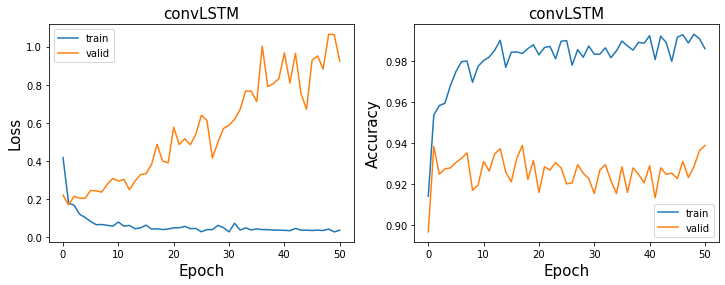

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(65, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=3000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.38751500844955444
Val loss for epoch 0: 0.17977726459503174
Train loss for epoch 1: 0.24040842056274414
Val loss for epoch 1: 0.2132759690284729
Train loss for epoch 2: 0.21521525084972382
Val loss for epoch 2: 0.21074260771274567
Train loss for epoch 3: 0.18885920941829681
Val loss for epoch 3: 0.2398015260696411
Train loss for epoch 4: 0.1613006293773651
Val loss for epoch 4: 0.24192413687705994
Train loss for epoch 5: 0.15528170764446259
Val loss for epoch 5: 0.23135629296302795
Train loss for epoch 6: 0.14754393696784973
Val loss for epoch 6: 0.23328134417533875
Train loss for epoch 7: 0.14949321746826172
Val loss for epoch 7: 0.27389204502105713
Train loss f

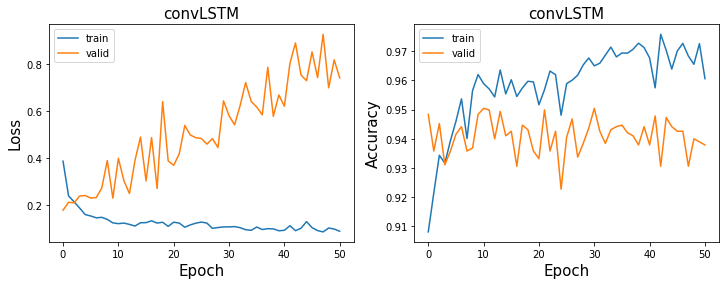

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(65, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=3000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.42732030153274536
Val loss for epoch 0: 0.35593485832214355
1
Train loss for epoch 1: 0.36306121945381165
Val loss for epoch 1: 0.3053884208202362
Train loss for epoch 2: 0.30311891436576843
Val loss for epoch 2: 0.3104665279388428
Train loss for epoch 3: 0.27641892433166504
Val loss for epoch 3: 0.32496628165245056
4
Train loss for epoch 4: 0.25091075897216797
Val loss for epoch 4: 0.2780671715736389
Train loss for epoch 5: 0.24628885090351105
Val loss for epoch 5: 0.3354053497314453
Train loss for epoch 6: 0.24943825602531433
Val loss for epoch 6: 0.32426917552948
Train loss for epoch 7: 0.24782295525074005
Val loss for epoch 7: 0.2885541617870331
8
Train loss 

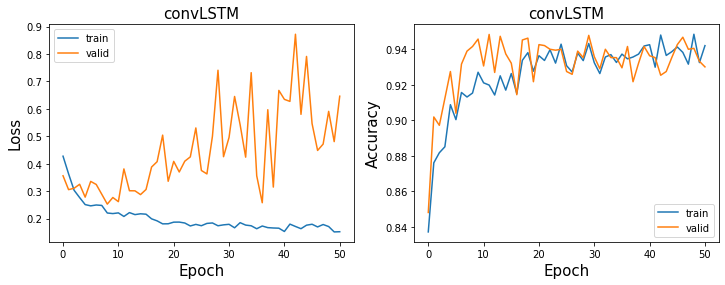

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(65, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.7, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=3000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.47770315408706665
Val loss for epoch 0: 0.6302893161773682
1
Train loss for epoch 1: 0.4097852110862732
Val loss for epoch 1: 0.21851804852485657
2
Train loss for epoch 2: 0.36988937854766846
Val loss for epoch 2: 0.18880948424339294
Train loss for epoch 3: 0.3642553687095642
Val loss for epoch 3: 0.385487824678421
Train loss for epoch 4: 0.35871633887290955
Val loss for epoch 4: 0.2193460762500763
Train loss for epoch 5: 0.34232306480407715
Val loss for epoch 5: 0.27482861280441284
Train loss for epoch 6: 0.31784361600875854
Val loss for epoch 6: 0.3302045166492462
Train loss for epoch 7: 0.3088652193546295
Val loss for epoch 7: 0.3365548551082611
Train loss for

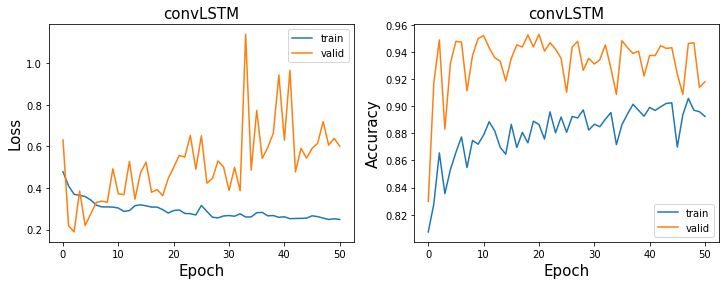

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(65, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.9, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=3000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.5942995548248291
Val loss for epoch 0: 0.5296165347099304
Train loss for epoch 1: 0.568806529045105
Val loss for epoch 1: 0.6753724217414856
Train loss for epoch 2: 0.564590334892273
Val loss for epoch 2: 0.9273920655250549
Train loss for epoch 3: 0.5718438029289246
Val loss for epoch 3: 0.6506457328796387
Train loss for epoch 4: 0.5669742226600647
Val loss for epoch 4: 0.6021576523780823
Train loss for epoch 5: 0.5560503005981445
Val loss for epoch 5: 0.6187016367912292
Train loss for epoch 6: 0.5522739291191101
Val loss for epoch 6: 0.6872618794441223
7
Train loss for epoch 7: 0.5478156805038452
Val loss for epoch 7: 0.4386206269264221
Train loss for epoch 8: 0

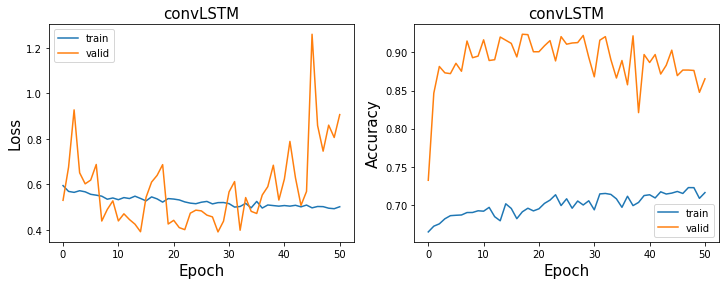

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.5437430143356323
Val loss for epoch 0: 0.221930131316185
Train loss for epoch 1: 0.19892160594463348
Val loss for epoch 1: 0.26617294549942017
Train loss for epoch 2: 0.11894848942756653
Val loss for epoch 2: 0.45802041888237
Train loss for epoch 3: 0.13280880451202393
Val loss for epoch 3: 0.3527631163597107
Train loss for epoch 4: 0.0854329988360405
Val loss for epoch 4: 0.7497449517250061
Train loss for epoch 5: 0.08128412812948227
Val loss for epoch 5: 0.5315731763839722
Train loss for epoch 6: 0.058203380554914474
Val loss for epoch 6: 0.46328774094581604
Train loss for epoch 7: 0.0659739077091217
Val loss for epoch 7: 1.088709831237793
Train loss for epoch

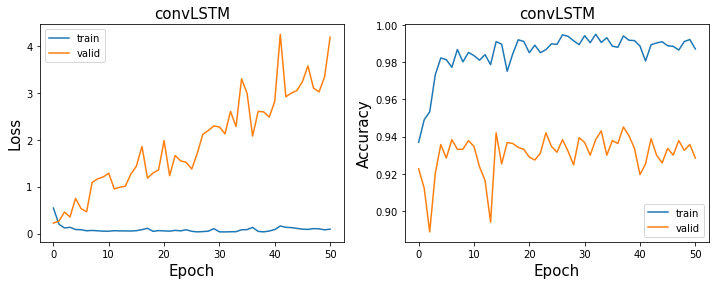

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.5920579433441162
Val loss for epoch 0: 0.22922924160957336
Train loss for epoch 1: 0.23962417244911194
Val loss for epoch 1: 0.2531917095184326
Train loss for epoch 2: 0.19222477078437805
Val loss for epoch 2: 0.30479443073272705
Train loss for epoch 3: 0.17006570100784302
Val loss for epoch 3: 0.8673087358474731
Train loss for epoch 4: 0.15985658764839172
Val loss for epoch 4: 0.4804530143737793
Train loss for epoch 5: 0.1907542645931244
Val loss for epoch 5: 0.6873209476470947
Train loss for epoch 6: 0.14575713872909546
Val loss for epoch 6: 0.9036269783973694
Train loss for epoch 7: 0.12265754491090775
Val loss for epoch 7: 0.6968744993209839
Train loss for e

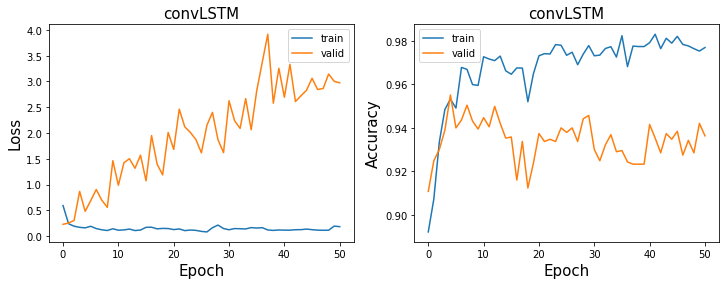

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.6829724311828613
Val loss for epoch 0: 0.2177799940109253
Train loss for epoch 1: 0.2929481565952301
Val loss for epoch 1: 0.3605693280696869
Train loss for epoch 2: 0.26873624324798584
Val loss for epoch 2: 0.3900777995586395
Train loss for epoch 3: 0.22840017080307007
Val loss for epoch 3: 0.4062190651893616
Train loss for epoch 4: 0.24937912821769714
Val loss for epoch 4: 0.5699540972709656
Train loss for epoch 5: 0.2107321321964264
Val loss for epoch 5: 1.1155470609664917
Train loss for epoch 6: 0.18932481110095978
Val loss for epoch 6: 0.5428844094276428
Train loss for epoch 7: 0.21184124052524567
Val loss for epoch 7: 0.5004878044128418
Train loss for epoc

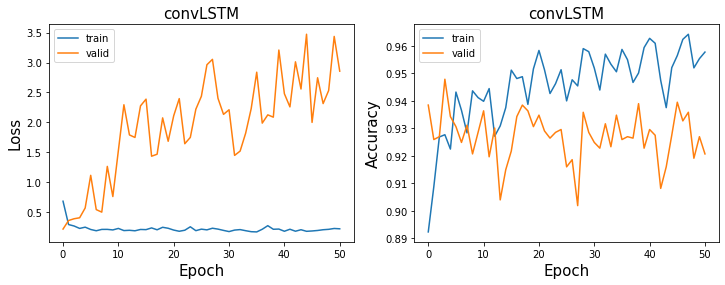

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.7, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.49455904960632324
Val loss for epoch 0: 0.2611296772956848
Train loss for epoch 1: 0.3969719707965851
Val loss for epoch 1: 0.532372236251831
Train loss for epoch 2: 0.3412051796913147
Val loss for epoch 2: 0.6668829917907715
Train loss for epoch 3: 0.34295615553855896
Val loss for epoch 3: 0.7337196469306946
Train loss for epoch 4: 0.332184761762619
Val loss for epoch 4: 0.6367818117141724
Train loss for epoch 5: 0.32390090823173523
Val loss for epoch 5: 0.5487319231033325
Train loss for epoch 6: 0.3350403606891632
Val loss for epoch 6: 0.7816101908683777
Train loss for epoch 7: 0.3122175335884094
Val loss for epoch 7: 0.6033658385276794
Train loss for epoch 8:

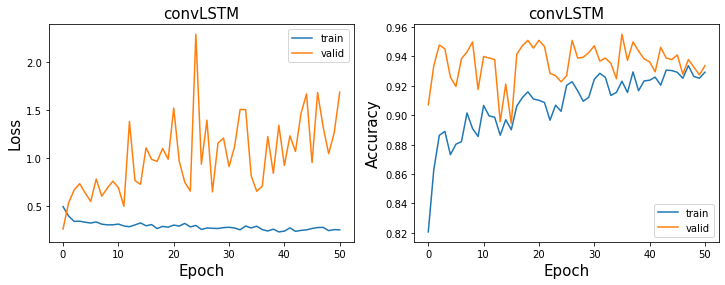

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.9, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.5180571675300598
Val loss for epoch 0: 1.1834951639175415
1
Train loss for epoch 1: 0.48241958022117615
Val loss for epoch 1: 0.6715710759162903
Train loss for epoch 2: 0.4910072386264801
Val loss for epoch 2: 0.8232220411300659
Train loss for epoch 3: 0.4708576500415802
Val loss for epoch 3: 0.8904691934585571
Train loss for epoch 4: 0.4614850580692291
Val loss for epoch 4: 0.7899158596992493
5
Train loss for epoch 5: 0.44147682189941406
Val loss for epoch 5: 0.5977691411972046
Train loss for epoch 6: 0.4341963529586792
Val loss for epoch 6: 0.7204928398132324
7
Train loss for epoch 7: 0.42538541555404663
Val loss for epoch 7: 0.5133523344993591
Train loss for 

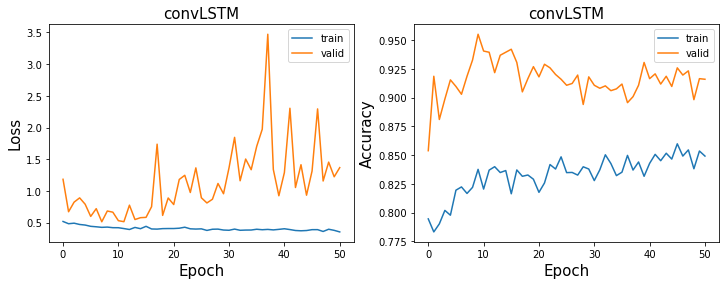

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 48.70893096923828
Val loss for epoch 0: 16.807796478271484
1
Train loss for epoch 1: 50.000003814697266
Val loss for epoch 1: 16.807796478271484
2
Train loss for epoch 2: 50.009647369384766
Val loss for epoch 2: 16.807796478271484
3
Train loss for epoch 3: 49.99311447143555
Val loss for epoch 3: 16.807796478271484
4
Train loss for epoch 4: 50.00413513183594
Val loss for epoch 4: 16.807796478271484
5
Train loss for epoch 5: 50.00275802612305
Val loss for epoch 5: 16.807796478271484
6
Train loss for epoch 6: 50.00413513183594
Val loss for epoch 6: 16.807796478271484
7
Train loss for epoch 7: 50.000003814697266
Val loss for epoch 7: 16.807796478271484
8
Train loss 

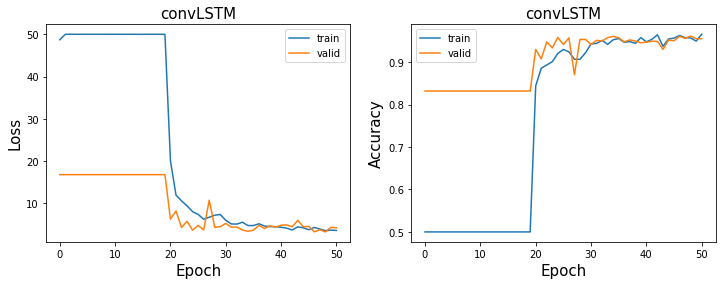

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 9.162951469421387
Val loss for epoch 0: 3.675290584564209
1
Train loss for epoch 1: 5.47967529296875
Val loss for epoch 1: 3.458874225616455
Train loss for epoch 2: 4.12526273727417
Val loss for epoch 2: 4.564716339111328
Train loss for epoch 3: 3.9307920932769775
Val loss for epoch 3: 7.6692118644714355
4
Train loss for epoch 4: 3.7760603427886963
Val loss for epoch 4: 3.189077377319336
5
Train loss for epoch 5: 3.343708038330078
Val loss for epoch 5: 3.0180606842041016
Train loss for epoch 6: 2.7481849193573
Val loss for epoch 6: 3.739661693572998
7
Train loss for epoch 7: 2.7697365283966064
Val loss for epoch 7: 2.8110718727111816
Train loss for epoch 8: 2.83

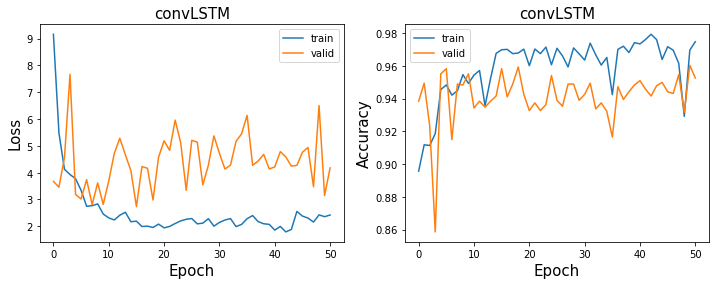

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 7.539961814880371
Val loss for epoch 0: 2.4562065601348877
Train loss for epoch 1: 4.211751461029053
Val loss for epoch 1: 2.9799747467041016
Train loss for epoch 2: 3.0728259086608887
Val loss for epoch 2: 4.167588710784912
Train loss for epoch 3: 2.631373405456543
Val loss for epoch 3: 3.186216354370117
Train loss for epoch 4: 2.6274194717407227
Val loss for epoch 4: 6.547758102416992
Train loss for epoch 5: 2.4645118713378906
Val loss for epoch 5: 3.9532294273376465
Train loss for epoch 6: 2.4223179817199707
Val loss for epoch 6: 5.673016548156738
Train loss for epoch 7: 2.464505195617676
Val loss for epoch 7: 3.275912284851074
Train loss for epoch 8: 2.11522

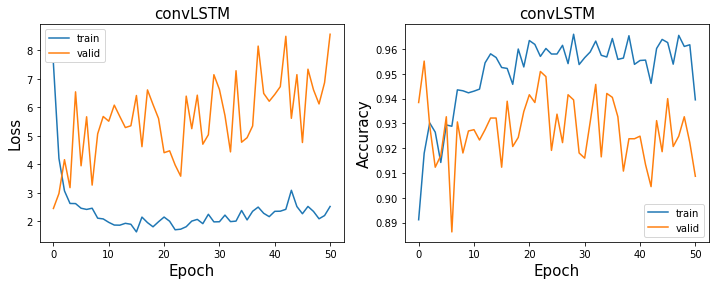

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.7, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 1.8860336542129517
Val loss for epoch 0: 2.3694586753845215
1
Train loss for epoch 1: 1.1802185773849487
Val loss for epoch 1: 1.9302659034729004
Train loss for epoch 2: 1.031928539276123
Val loss for epoch 2: 2.717968225479126
Train loss for epoch 3: 1.0366204977035522
Val loss for epoch 3: 4.766383171081543
Train loss for epoch 4: 1.2305831909179688
Val loss for epoch 4: 3.184384346008301
Train loss for epoch 5: 1.0532050132751465
Val loss for epoch 5: 5.179387092590332
Train loss for epoch 6: 1.1671022176742554
Val loss for epoch 6: 5.767632961273193
Train loss for epoch 7: 1.4064078330993652
Val loss for epoch 7: 3.7064409255981445
Train loss for epoch 8: 1.

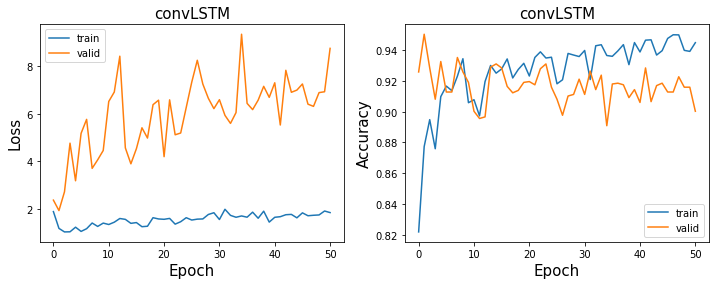

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.9, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.7684566974639893
Val loss for epoch 0: 2.365173578262329
1
Train loss for epoch 1: 0.6837008595466614
Val loss for epoch 1: 1.6125227212905884
Train loss for epoch 2: 0.7014591097831726
Val loss for epoch 2: 1.8988137245178223
3
Train loss for epoch 3: 0.6449272036552429
Val loss for epoch 3: 1.4275004863739014
Train loss for epoch 4: 0.7136114239692688
Val loss for epoch 4: 1.6387901306152344
Train loss for epoch 5: 0.7213308811187744
Val loss for epoch 5: 1.8483408689498901
6
Train loss for epoch 6: 0.673592746257782
Val loss for epoch 6: 1.2942931652069092
Train loss for epoch 7: 0.7151332497596741
Val loss for epoch 7: 2.2510788440704346
Train loss for epo

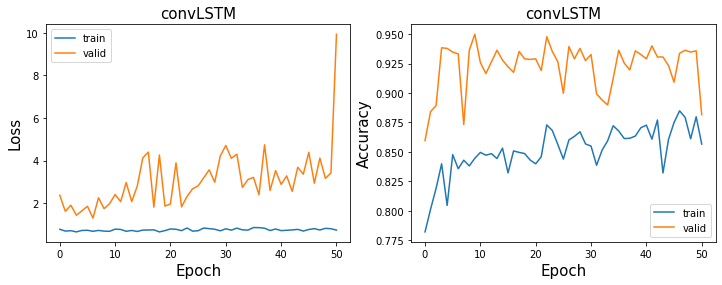

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 48.873252868652344
Val loss for epoch 0: 16.807796478271484
1
Train loss for epoch 1: 49.980712890625
Val loss for epoch 1: 16.807796478271484
2
Train loss for epoch 2: 49.998626708984375
Val loss for epoch 2: 16.807796478271484
3
Train loss for epoch 3: 50.00275802612305
Val loss for epoch 3: 16.807796478271484
4
Train loss for epoch 4: 50.00137710571289
Val loss for epoch 4: 16.807796478271484
5
Train loss for epoch 5: 50.00275802612305
Val loss for epoch 5: 16.807796478271484
6
Train loss for epoch 6: 49.99449157714844
Val loss for epoch 6: 16.807796478271484
7
Train loss for epoch 7: 50.000003814697266
Val loss for epoch 7: 16.807796478271484
8
Train loss fo

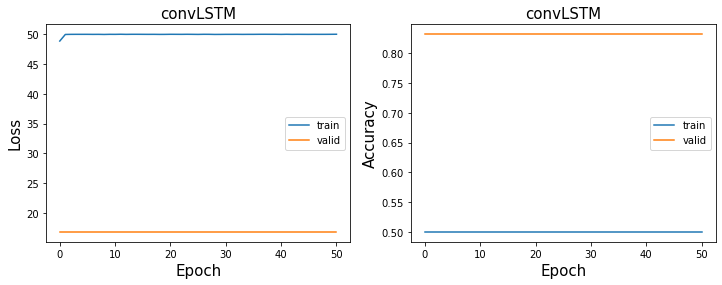

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 11.352133750915527
Val loss for epoch 0: 4.050459861755371
1
Train loss for epoch 1: 6.344773769378662
Val loss for epoch 1: 2.2858872413635254
Train loss for epoch 2: 4.731087684631348
Val loss for epoch 2: 3.683875560760498
Train loss for epoch 3: 3.882528066635132
Val loss for epoch 3: 2.6302506923675537
Train loss for epoch 4: 4.286651611328125
Val loss for epoch 4: 4.841367721557617
Train loss for epoch 5: 3.879096508026123
Val loss for epoch 5: 4.507106304168701
Train loss for epoch 6: 3.032101631164551
Val loss for epoch 6: 4.486442565917969
Train loss for epoch 7: 3.3972277641296387
Val loss for epoch 7: 3.2211170196533203
Train loss for epoch 8: 3.54270

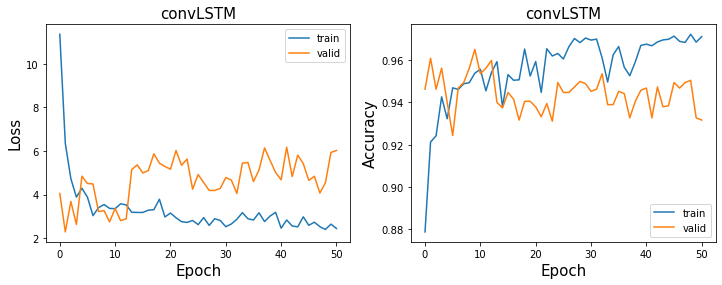

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 7.213892459869385
Val loss for epoch 0: 3.1535232067108154
1
Train loss for epoch 1: 3.331409454345703
Val loss for epoch 1: 2.895817995071411
Train loss for epoch 2: 2.808107852935791
Val loss for epoch 2: 4.871155261993408
Train loss for epoch 3: 2.587707281112671
Val loss for epoch 3: 5.214979648590088
Train loss for epoch 4: 2.4768710136413574
Val loss for epoch 4: 5.017186641693115
Train loss for epoch 5: 1.968498945236206
Val loss for epoch 5: 4.040553092956543
Train loss for epoch 6: 2.0549535751342773
Val loss for epoch 6: 3.976392984390259
Train loss for epoch 7: 2.1902225017547607
Val loss for epoch 7: 4.803616523742676
Train loss for epoch 8: 1.963940

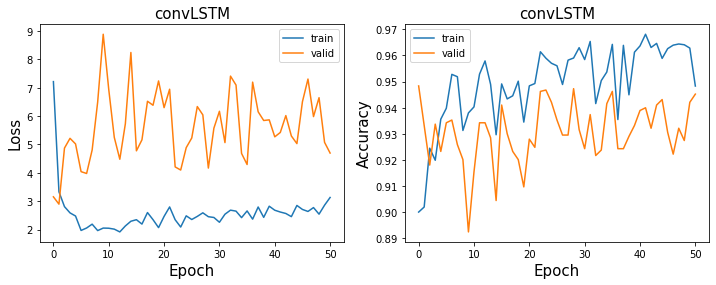

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.7, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 2.5279273986816406
Val loss for epoch 0: 3.7831618785858154
Train loss for epoch 1: 1.7339844703674316
Val loss for epoch 1: 4.650935173034668
2
Train loss for epoch 2: 1.573262333869934
Val loss for epoch 2: 2.8055200576782227
Train loss for epoch 3: 1.6343135833740234
Val loss for epoch 3: 4.416176795959473
Train loss for epoch 4: 1.5537669658660889
Val loss for epoch 4: 4.122515678405762
Train loss for epoch 5: 1.607353687286377
Val loss for epoch 5: 6.999179363250732
Train loss for epoch 6: 1.7076961994171143
Val loss for epoch 6: 5.9070725440979
Train loss for epoch 7: 1.679430603981018
Val loss for epoch 7: 6.909272193908691
Train loss for epoch 8: 1.95615

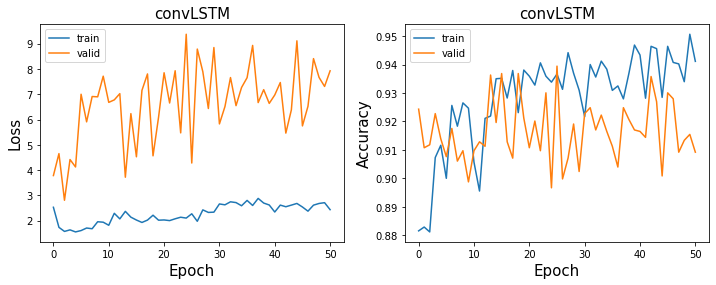

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.9, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.8603388071060181
Val loss for epoch 0: 1.8115376234054565
Train loss for epoch 1: 0.7884158492088318
Val loss for epoch 1: 3.0881195068359375
2
Train loss for epoch 2: 0.7892720103263855
Val loss for epoch 2: 1.5445507764816284
Train loss for epoch 3: 0.8959686160087585
Val loss for epoch 3: 2.0005548000335693
Train loss for epoch 4: 0.7974987030029297
Val loss for epoch 4: 2.6345269680023193
Train loss for epoch 5: 0.8059043288230896
Val loss for epoch 5: 2.224255323410034
Train loss for epoch 6: 0.8358004689216614
Val loss for epoch 6: 2.4247217178344727
Train loss for epoch 7: 0.7985479831695557
Val loss for epoch 7: 2.731396436691284
Train loss for epoch 8

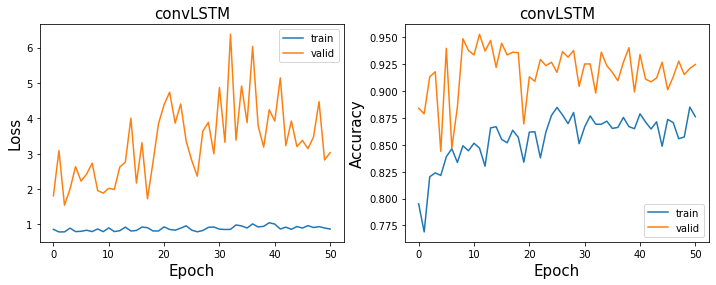

In [16]:
for i in hidden_dim:
    for d in dropout:
        model = convLSTM(input_dim = 62, hidden_dim = i, dropout = d).to(device)
        print(model)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        criterion = nn.BCELoss() # BCE loss
        train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]

        for epoch in range(num_epochs):
            train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
            val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            if epoch == 0:
                torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_DO{}_HD{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,d, i,epoch))
            if val_loss <= min(val_losses):
                best_epoch = epoch
                print(epoch)
                print('Train loss for epoch {}: {}'.format(epoch, train_loss))
                print('Val loss for epoch {}: {}'.format(epoch, val_loss))
                torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_DO{}_HD{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,d, i,epoch))
        #     elif verbose:
            else:
                print('Train loss for epoch {}: {}'.format(epoch, train_loss))
                print('Val loss for epoch {}: {}'.format(epoch, val_loss))

        #     if epoch == num_epochs-1:
        #         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))

        plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [17]:
# train_result_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_DO{}_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, dropout)
# print(train_result_filename)

/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_DO0.3_trainresult.pt


In [18]:
# train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}

# pickle.dump( train_result, open( train_result_filename, "wb" ) )

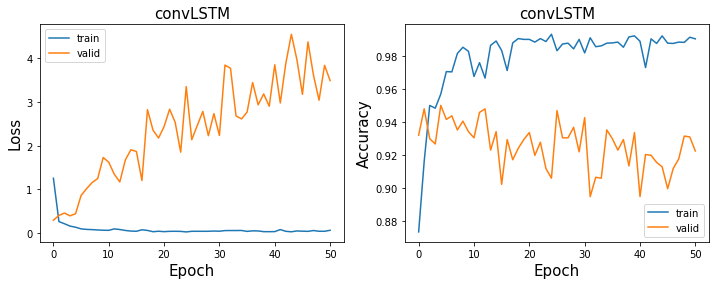

In [19]:
train_result = pickle.load(open(train_result_filename, "rb" ))
plot_loss_acc( train_result['train_losses'],  train_result['val_losses'],  train_result['train_accs'],  train_result['val_accs'],  train_result['model_type'])

In [20]:
model_convLSTM = os.listdir(model_saving_path)
results = []
best_result = 0
reg_alpha = 'REG'+reg_type+str(alpha)+'_'
dropout_type = 'DO_'+str(dropout)
for i, s in enumerate(model_convLSTM):
    if 'convLSTM_CHall_' in s and reg_alpha in s and dropout_type in s and 'trainresult' not in s:
        model_name = model_convLSTM[i].split('_')
        epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
        res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
        if len(res) > 1:
            epoch_result = res[0]*10+res[1]
        else:
            epoch_result = res[0]
        if epoch_result>best_result and epoch_result != 50:
            best_result = epoch_result

results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0          0


/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_DO0.3_EPOCH0.pt


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.2961771786212921 accuracy:0.9319148936170213
/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_DO0.3_valcm.pt


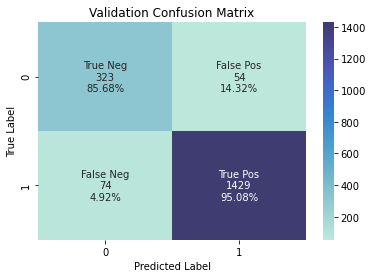

In [21]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    alpha = index
    
    
    # load best model
    model = convLSTM(input_dim = 62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_DO{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, dropout, best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_DO{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,dropout, best_epoch))

    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
#     ## Calculate test accuracy and test loss
# #     test_loss, test_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
# #     print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
# #     print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_DO{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, dropout)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
#     ## Confusion matrix-test
#     predictions_test = np.concatenate(test_preds)
#     labels_test = np.concatenate(test_labels)

#     df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

#     cm_test = confusion_matrix(labels_test, predictions_test)
#     ax = plt.axes()
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                     cm_test.flatten()]

#     TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
#     FPR = 1 - TNR
#     TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
#     FNR = 1-TPR
#     group_percentages =[TNR, FPR, FNR, TPR]

#     group_percentages = ["{0:.2%}".format(value) for value in
#                          group_percentages]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
#     ax.set_title('Test Confusion Matrix')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()
    


## T-length = 5

In [22]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=3)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [23]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [24]:
## Upsample train
train_files = upsample(train_files)

In [25]:
len(train_files), len(val_files), len(test_files)

(6092, 1880, 1870)

In [26]:
## Load files to dataloader
T_length = 5

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=T_length, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

### Training

In [27]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
# verbose = False


model = convLSTM(input_dim = 62).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 0.9084922075271606
Val loss for epoch 0: 0.26200735569000244
Train loss for epoch 1: 0.3128635585308075
Val loss for epoch 1: 0.7093961238861084
Train loss for epoch 2: 0.23529702425003052
Val loss for epoch 2: 0.3536820709705353
Train loss for epoch 3: 0.20218798518180847
Val loss for epoch 3: 0.5785936117172241
Train loss for epoch 4: 0.15365566313266754
Val loss for epoch 4: 1.1768420934677124
Train loss for epoch 5: 0.12144237011671066
Val loss for epoch 5: 0.5663346648216248
Train loss for epoch 6: 0.09473332017660141
Val loss for epoch 6: 0.951814591884613
Train loss for epoch 7: 0.09066018462181091
Val loss for epoch 7: 1.2871695756912231
Train loss for epoch 8: 0.08702792227268219
Val loss for epoch 8: 0.8814448118209839
Train loss for epoch 9: 0.07091366499662399
Val loss for epoch 9: 2.071255922317505
Train loss for epoch 10: 0.0855061337351799
Val loss for epoch 10: 1.8266583681106567
Train loss for epoch 11: 0.08298634737730026
Val loss for epoch 1

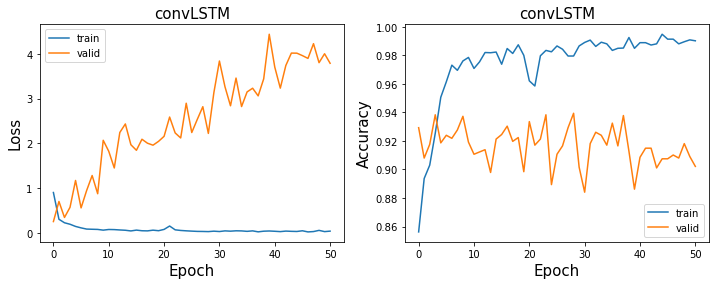

In [28]:
train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]
 
for epoch in range(num_epochs):
    train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
    val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, epoch))
#     elif verbose:
    else:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
#     if epoch == num_epochs-1:
#         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [29]:
train_result_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length,dropout)
print(train_result_filename)

/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH5_DO0.3_trainresult.pt


In [30]:
train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}

pickle.dump( train_result, open( train_result_filename, "wb" ) )

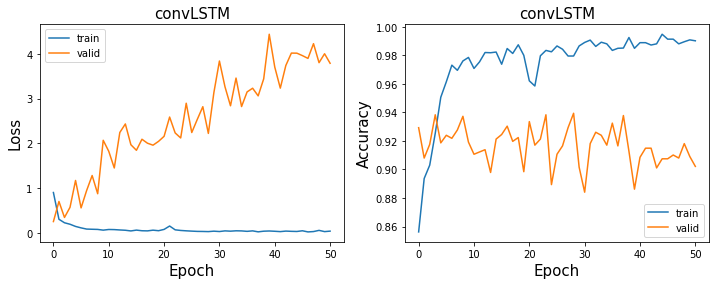

In [31]:
train_result = pickle.load(open(train_result_filename, "rb" ))
plot_loss_acc( train_result['train_losses'],  train_result['val_losses'],  train_result['train_accs'],  train_result['val_accs'],  train_result['model_type'])

In [32]:
model_convLSTM = os.listdir(model_saving_path)
results = []
best_result = 0
reg_alpha = 'REG'+reg_type+str(alpha)+'_'
tlength = 'TLENGTH'+str(T_length)
dropout_type = 'DO'+str(dropout)
for i, s in enumerate(model_convLSTM):
    if 'convLSTM_CHall_' in s and reg_alpha in s and 'trainresult' not in s and tlength in s and dropout_type in s and 'valcm' not in s:
        model_name = model_convLSTM[i].split('_')
        epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
        res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
        if len(res) > 1:
            epoch_result = res[0]*10+res[1]
        else:
            epoch_result = res[0]
        if epoch_result>best_result and epoch_result != 50:
            best_result = epoch_result

results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0          0


/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH5_DO0.3_EPOCH0.pt


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.26200735569000244 accuracy:0.9292553191489362
/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH5_DO0.3_valcm.pt


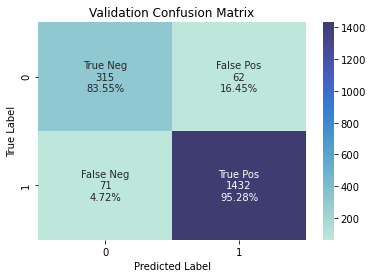

In [33]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    alpha = index
    
    
    # load best model
    model = convLSTM(input_dim = 62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length,dropout, best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, dropout, best_epoch))

    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
#     ## Calculate test accuracy and test loss
# #     test_loss, test_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
# #     print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
# #     print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
#     ## Confusion matrix-test
#     predictions_test = np.concatenate(test_preds)
#     labels_test = np.concatenate(test_labels)

#     df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

#     cm_test = confusion_matrix(labels_test, predictions_test)
#     ax = plt.axes()
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                     cm_test.flatten()]

#     TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
#     FPR = 1 - TNR
#     TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
#     FNR = 1-TPR
#     group_percentages =[TNR, FPR, FNR, TPR]

#     group_percentages = ["{0:.2%}".format(value) for value in
#                          group_percentages]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
#     ax.set_title('Test Confusion Matrix')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()
    


## T-length = 10

In [34]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=3)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [35]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [36]:
## Upsample train
train_files = upsample(train_files)

In [37]:
len(train_files), len(val_files), len(test_files)

(6092, 1880, 1870)

In [38]:
## Load files to dataloader
T_length = 10

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=T_length, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

### Training

In [39]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
droput = 0.3
# verbose = False


model = convLSTM(input_dim = 62).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 0.8753038644790649
Val loss for epoch 0: 0.45029881596565247
1
Train loss for epoch 1: 0.2892386317253113
Val loss for epoch 1: 0.33146050572395325
Train loss for epoch 2: 0.19783514738082886
Val loss for epoch 2: 0.7201007604598999
Train loss for epoch 3: 0.12071020901203156
Val loss for epoch 3: 0.38213837146759033
Train loss for epoch 4: 0.0924542173743248
Val loss for epoch 4: 0.5670458078384399
Train loss for epoch 5: 0.10220860689878464
Val loss for epoch 5: 1.3060094118118286
Train loss for epoch 6: 0.11082440614700317
Val loss for epoch 6: 0.9284374713897705
Train loss for epoch 7: 0.09133395552635193
Val loss for epoch 7: 0.9676240682601929
Train loss for epoch 8: 0.0811803936958313
Val loss for epoch 8: 1.2209725379943848
Train loss for epoch 9: 0.059139274060726166
Val loss for epoch 9: 1.2029730081558228
Train loss for epoch 10: 0.039870068430900574
Val loss for epoch 10: 2.395979404449463
Train loss for epoch 11: 0.04359031468629837
Val loss for e

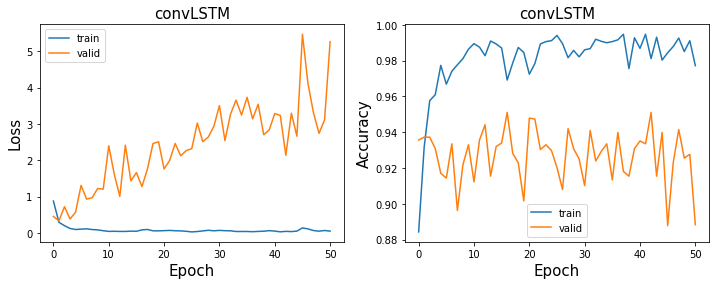

In [40]:
train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]
 
for epoch in range(num_epochs):
    train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
    val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length,dropout, epoch))
#     elif verbose:
    else:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
#     if epoch == num_epochs-1:
#         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [41]:
train_result_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout)
print(train_result_filename)

/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_DO0.3_trainresult.pt


In [42]:
train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}

pickle.dump( train_result, open( train_result_filename, "wb" ) )

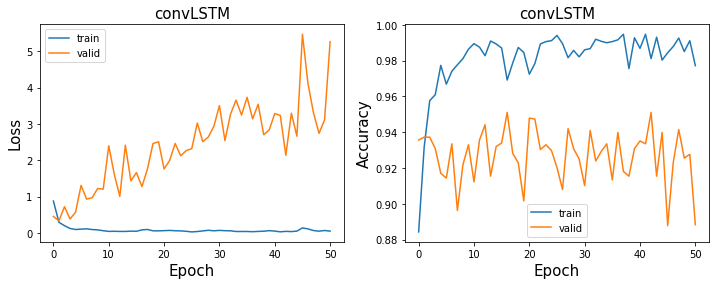

In [43]:
train_result = pickle.load(open(train_result_filename, "rb" ))
plot_loss_acc( train_result['train_losses'],  train_result['val_losses'],  train_result['train_accs'],  train_result['val_accs'],  train_result['model_type'])

In [44]:
model_convLSTM = os.listdir(model_saving_path)
results = []
best_result = 0
reg_alpha = 'REG'+reg_type+str(alpha)+'_'
tlength = 'TLENGTH'+str(T_length)
dropout_type = 'DO'+str(dropout)
for i, s in enumerate(model_convLSTM):
    if 'convLSTM_CHall_' in s and reg_alpha in s and 'trainresult' not in s and tlength in s and dropout_type in s and 'valcm' not in s:
        model_name = model_convLSTM[i].split('_')
        epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
        res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
        if len(res) > 1:
            epoch_result = res[0]*10+res[1]
        else:
            epoch_result = res[0]
        if epoch_result>best_result and epoch_result != 50:
            best_result = epoch_result

results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0          1


/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_DO0.3_EPOCH1.pt


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.33146050572395325 accuracy:0.9372340425531915
/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_DO0.3_valcm.pt


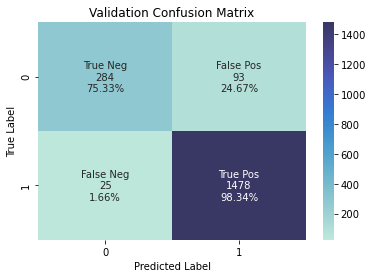

In [45]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    alpha = index
    
    
    # load best model
    model = convLSTM(input_dim = 62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, dropout,best_epoch))

    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
#     ## Calculate test accuracy and test loss
# #     test_loss, test_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
# #     print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
# #     print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
#     ## Confusion matrix-test
#     predictions_test = np.concatenate(test_preds)
#     labels_test = np.concatenate(test_labels)

#     df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

#     cm_test = confusion_matrix(labels_test, predictions_test)
#     ax = plt.axes()
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                     cm_test.flatten()]

#     TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
#     FPR = 1 - TNR
#     TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
#     FNR = 1-TPR
#     group_percentages =[TNR, FPR, FNR, TPR]

#     group_percentages = ["{0:.2%}".format(value) for value in
#                          group_percentages]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
#     ax.set_title('Test Confusion Matrix')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()
    


## T-length = 3, DO = [0.1,0.5]

In [58]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=3)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [59]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [60]:
## Upsample train
train_files = upsample(train_files)

In [61]:
len(train_files), len(val_files), len(test_files)

(6092, 1880, 1870)

In [62]:
## Load files to dataloader
T_length = 3
train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=T_length, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

### Training

In [68]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
dropouts = [0.1,0.5]
# verbose = False
criterion = nn.BCELoss() # BCE loss

for do in dropouts:
    model = convLSTM(input_dim = 62, dropout = do).to(device)
    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


    train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]

In [70]:


for epoch in range(num_epochs):
    train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
    val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length,dropout, epoch))
#     elif verbose:
    else:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))

#     if epoch == num_epochs-1:
#         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

TypeError: 'BCELoss' object is not iterable

In [41]:
train_result_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout)
print(train_result_filename)

/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_DO0.3_trainresult.pt


In [42]:
train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}

pickle.dump( train_result, open( train_result_filename, "wb" ) )

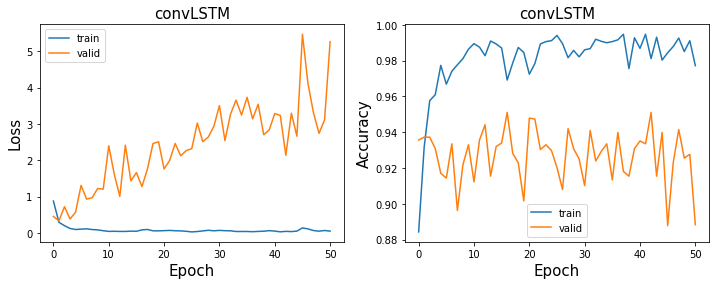

In [43]:
train_result = pickle.load(open(train_result_filename, "rb" ))
plot_loss_acc( train_result['train_losses'],  train_result['val_losses'],  train_result['train_accs'],  train_result['val_accs'],  train_result['model_type'])

In [44]:
model_convLSTM = os.listdir(model_saving_path)
results = []
best_result = 0
reg_alpha = 'REG'+reg_type+str(alpha)+'_'
tlength = 'TLENGTH'+str(T_length)
dropout_type = 'DO'+str(dropout)
for i, s in enumerate(model_convLSTM):
    if 'convLSTM_CHall_' in s and reg_alpha in s and 'trainresult' not in s and tlength in s and dropout_type in s and 'valcm' not in s:
        model_name = model_convLSTM[i].split('_')
        epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
        res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
        if len(res) > 1:
            epoch_result = res[0]*10+res[1]
        else:
            epoch_result = res[0]
        if epoch_result>best_result and epoch_result != 50:
            best_result = epoch_result

results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0          1


/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_DO0.3_EPOCH1.pt


<ipython-input-13-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.33146050572395325 accuracy:0.9372340425531915
/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLENGTH10_DO0.3_valcm.pt


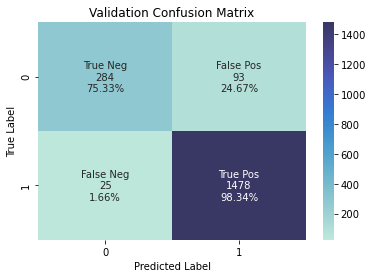

In [45]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    alpha = index
    
    
    # load best model
    model = convLSTM(input_dim = 62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, dropout,best_epoch))

    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
#     ## Calculate test accuracy and test loss
# #     test_loss, test_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
# #     print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
# #     print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLENGTH{}_DO{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
#     ## Confusion matrix-test
#     predictions_test = np.concatenate(test_preds)
#     labels_test = np.concatenate(test_labels)

#     df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

#     cm_test = confusion_matrix(labels_test, predictions_test)
#     ax = plt.axes()
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                     cm_test.flatten()]

#     TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
#     FPR = 1 - TNR
#     TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
#     FNR = 1-TPR
#     group_percentages =[TNR, FPR, FNR, TPR]

#     group_percentages = ["{0:.2%}".format(value) for value in
#                          group_percentages]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
#     ax.set_title('Test Confusion Matrix')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()
    
